In [1]:
import numpy as np
import sys

from intervaltree import IntervalTree
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.patches as patches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("..")
from analysis.snoRNA.find_snoRNA_peaks import load_bigWig
from scipy.signal import find_peaks

In [2]:
datum, list_of_snoRNA = load_bigWig()

list_of_coords = list(range(3660, 5527)) + list(range(7933, 13008))  # only 18S and 28S regions
datum = datum[:,list_of_coords]

scaled = (datum.T/datum.sum(axis=1)).T
normed = scaled - scaled.mean(axis=0)

scaled.shape, normed.shape

((114, 6942), (114, 6942))

In [3]:
dict_snoRNA = dict([ (snoRNA.split("+")[0].split("-")[1], no) for no, snoRNA in enumerate(list_of_snoRNA) ])

In [8]:
dict_known = {}
with open("../analysis/snoRNA/known_loci_SNORD.csv") as f:
    for no, line in enumerate(f):
        if no == 0:
            continue
        row = line.strip("\r\n").split(",")
        iid, locus_18S, locus_28S = row[0], int(row[1]), int(row[2])
        dict_known[iid] = (locus_18S, locus_28S)

### Combined

### 28S

In [13]:
f_pdb = "../analysis/validation/pdb/anger/anger_28S_rRNA_phosphate.txt"

def euclidean_dist(x, y):
    return np.sqrt(((x - y)**2).sum())

coords = {}
with open(f_pdb, "r") as f:
    for line in f:
        row = line.strip("\r\n").split("\t")
        nid, x, y, z = int(row[0]), float(row[1]), float(row[2]), float(row[3])
        coords[nid] = [[x, y, z]]

data_28S = np.zeros((5071, 5071))
for no1, (k1, v1) in enumerate(coords.items()):
    for no2, (k2, v2) in enumerate(coords.items()):

        centroid1 = np.array(v1).mean(axis=0)
        centroid2 = np.array(v2).mean(axis=0)

        data_28S[k1][k2] = euclidean_dist(centroid1, centroid2)

### 18S

In [14]:
f_pdb = "../analysis/validation/pdb/anger/anger_18S_rRNA_phosphate.txt"

coords = {}
with open(f_pdb, "r") as f:
    for line in f:
        row = line.strip("\r\n").split("\t")
        nid, x, y, z = int(row[0]), float(row[1]), float(row[2]), float(row[3])
        coords[nid] = [[x, y, z]]

data_18S = np.zeros((1870, 1870))
for no1, (k1, v1) in enumerate(coords.items()):
    for no2, (k2, v2) in enumerate(coords.items()):

        centroid1 = np.array(v1).mean(axis=0)
        centroid2 = np.array(v2).mean(axis=0)

        data_18S[k1][k2] = euclidean_dist(centroid1, centroid2)

### Plot

40
15


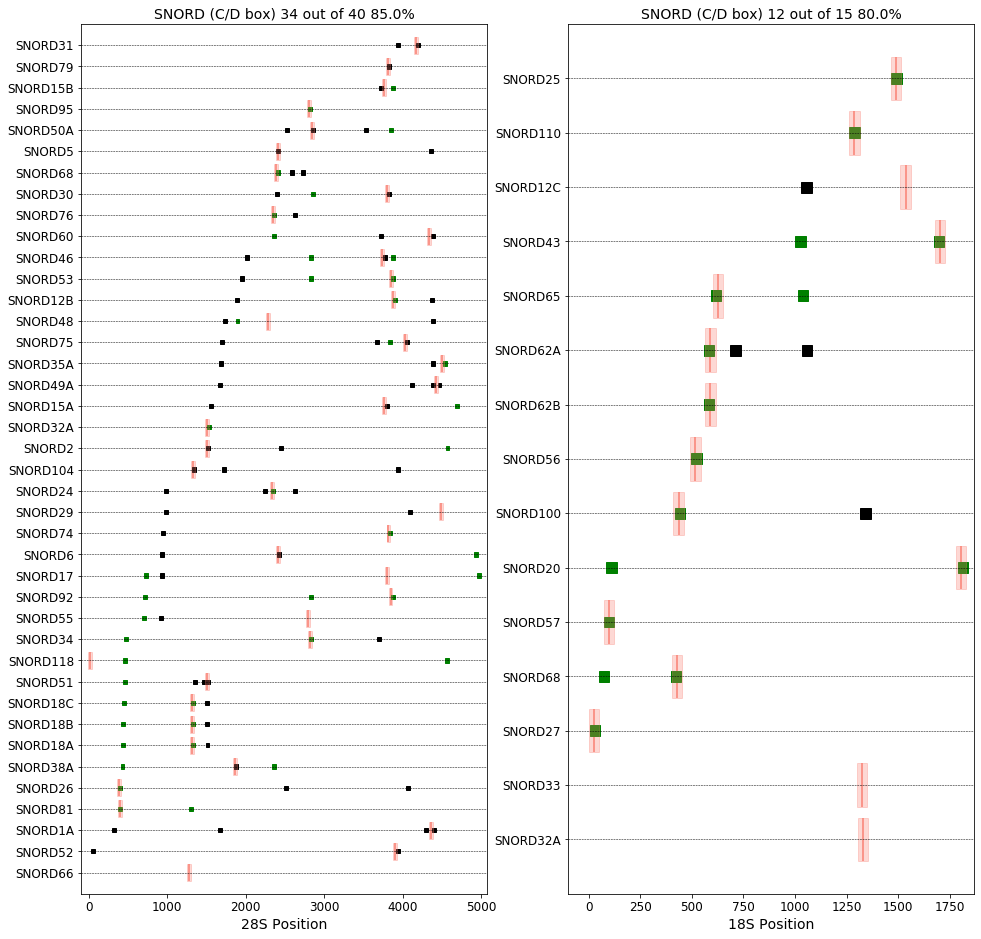

In [15]:
from intervaltree import IntervalTree


fig, ax = plt.subplots(1, 2, figsize=(16, 16))

# 28S
# -----------

list_of_eligible = [ k for k, (l1, l2) in dict_known.items() if l2 != -1 ]
print(len(list_of_eligible))


p_category = "28S"
p_width = 25
p_width_known = 25
p_correct = 0
p_min = 0
p_max = 50
p_offset = 0

list_of_sorted_eligible = []
for no, sno in enumerate(list_of_eligible):
    
    p_index = dict_snoRNA[sno]

    if p_category == "18S":
        profile = normed[p_index,:1867]
    elif p_category == "28S":
        profile = normed[p_index,1867:]

    # Peak
    peaks, properties = find_peaks(profile, width=10, distance=50, height=0.0003)

    if len(peaks) >= 1:
        min_locus = min(peaks)
    else:
        min_locus = 0
    list_of_sorted_eligible.append((sno, min_locus))

list_of_sorted_eligible = sorted(list_of_sorted_eligible, key=lambda q: q[1])


for no, (sno, m) in enumerate(list_of_sorted_eligible):
    
    p_index = dict_snoRNA[sno]

    if p_category == "18S":
        profile = normed[p_index,:1867]
    elif p_category == "28S":
        profile = normed[p_index,1867:]

    # Truth
    # ------
    p_anchor = dict_known[sno][0]

    # Get all proximal locations close to known peak
    # ------------------------------------------------
    proximals = np.where((data_28S[p_anchor] > p_min) & (data_28S[p_anchor] <= p_max))[0]
    list_of_coords = [ (p_anchor+p_offset, proximal+p_offset) if p_anchor < proximal else (proximal+p_offset, p_anchor+p_offset) for proximal in proximals ]

    tree_known = IntervalTree()
    for proximal in proximals:

        if (proximal < p_anchor+5) and (proximal > p_anchor-5):
            pass
        else:
            tree_known[proximal:proximal+1] = 1


    # Peak
    peaks, properties = find_peaks(profile, width=10, distance=50, height=0.0003)
    
    tree = IntervalTree()
    for peak in peaks:

        x0, x1 = peak-p_width, peak+p_width
        height = 0.2 #15
        y = no + 0.5

        result = tree_known[x0:x1]

        if len(result) == 0:
            rect = patches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor="black", facecolor="black")
        else:
            rect = patches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor="green", facecolor="green")
        
        ax[0].add_patch(rect)

        tree[x0:x1] = 1
    

    # Truth
    p_anchor = dict_known[sno][1]

    if len(tree[p_anchor-p_width_known:p_anchor+p_width_known]) >= 1:
        p_correct += 1

    x0, x1 = p_anchor-p_width_known, p_anchor+p_width_known
    height = 0.8 #0.75
    y = no + 0.5
    rect = patches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor='salmon', facecolor='salmon', alpha=0.3)
    ax[0].add_patch(rect)
    ax[0].axhline(no+0.5, linestyle="--", linewidth=0.5, color="black")
    ax[0].vlines(p_anchor, y-height/2, y+height/2, color="salmon", alpha=1.0, zorder=-1)

names = [ sno for sno, m in list_of_sorted_eligible ]
ax[0].set_yticks(np.array(range(len(names))) + 0.5)
ax[0].set_yticklabels(names)
ax[0].set_xlim(-100, 5075)
ax[0].set_ylim(-0.5, len(names)+0.5)
ax[0].set_xlabel("28S Position", fontsize=14)
ax[0].set_title("SNORD (C/D box) %s out of %s %.1f%%" % (p_correct, len(names), (p_correct/len(names))*100), fontsize=14)




# 18S
# -----------

list_of_eligible = [ k for k, (l1, l2) in dict_known.items() if l1 != -1 ]
print(len(list_of_eligible))

p_category = "18S"
p_width = 25
p_width_known = 25
p_correct = 0
p_min = 0
p_max = 50
p_offset = 0

list_of_sorted_eligible = []
for no, sno in enumerate(list_of_eligible):
    
    p_index = dict_snoRNA[sno]

    if p_category == "18S":
        profile = normed[p_index,:1867]
    elif p_category == "28S":
        profile = normed[p_index,1867:]

    # Peak
    peaks, properties = find_peaks(profile, width=10, distance=50, height=0.0002) #3)

    if len(peaks) >= 1:
        min_locus = min(peaks)
    else:
        min_locus = 0
    list_of_sorted_eligible.append((sno, min_locus))

list_of_sorted_eligible = sorted(list_of_sorted_eligible, key=lambda q: q[1])


for no, (sno, m) in enumerate(list_of_sorted_eligible):
    
    p_index = dict_snoRNA[sno]

    if p_category == "18S":
        profile = normed[p_index,:1867]
    elif p_category == "28S":
        profile = normed[p_index,1867:]

    # Truth
    # ------
    p_anchor = dict_known[sno][0]

    # Get all proximal locations close to known peak
    # ------------------------------------------------
    proximals = np.where((data_18S[p_anchor] > p_min) & (data_18S[p_anchor] <= p_max))[0]
    list_of_coords = [ (p_anchor+p_offset, proximal+p_offset) if p_anchor < proximal else (proximal+p_offset, p_anchor+p_offset) for proximal in proximals ]

    tree_known = IntervalTree()
    for proximal in proximals:

        if (proximal < p_anchor+5) and (proximal > p_anchor-5):
            pass
        else:
            tree_known[proximal:proximal+1] = 1


    # Peak
    peaks, properties = find_peaks(profile, width=10, distance=50, height=0.0002) #3)
    
    tree = IntervalTree()
    for peak in peaks:

        x0, x1 = peak-p_width, peak+p_width
        height = 0.2 #15
        y = no + 0.5

        result = tree_known[x0:x1]
        if len(result) == 0:
            rect = patches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor="black", facecolor="black")
        else:
            rect = patches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor="green", facecolor="green")
        ax[1].add_patch(rect)

        tree[x0:x1] = 1

    # Truth
    p_anchor = dict_known[sno][0]

    if len(tree[p_anchor-p_width_known:p_anchor+p_width_known]) >= 1:
        p_correct += 1

    x0, x1 = p_anchor-p_width_known, p_anchor+p_width_known
    height = 0.8 #0.75
    y = no + 0.5
    rect = patches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor='salmon', facecolor='salmon', alpha=0.3)
    ax[1].add_patch(rect)
    ax[1].axhline(no+0.5, linestyle="--", linewidth=0.5, color="black")
    ax[1].vlines(p_anchor, y-height/2, y+height/2, color="salmon", alpha=1.0, zorder=-1)
    
names = [ sno for sno, m in list_of_sorted_eligible ]
ax[1].set_yticks(np.array(range(len(names))) + 0.5)
ax[1].set_yticklabels(names)
ax[1].set_xlim(-100, 1867)
ax[1].set_ylim(-0.5, len(names)+0.5)
ax[1].set_xlabel("18S Position", fontsize=14)
ax[1].set_title("SNORD (C/D box) %s out of %s %.1f%%" % (p_correct, len(names), (p_correct/len(names))*100), fontsize=14)


ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

#plt.savefig("plot_snoRNA_peaks.png", dpi=300)
#plt.savefig("plot_snoRNA_peaks.pdf", dpi=300)